In [191]:
from skimage.io import imread
import numpy as np
from scipy.fft import dct, idct
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
import time


In [192]:
rootfolder = '../'

# Denoising

The goal of this section is to implement a simple denoising algorithm based on the 2D DCT. Given a noise free image $Y$, we observe a noisy version $S$:
$$
S = Y + \eta
$$
where $\eta\sim N(0, \sigma^2)$ denotes white Gaussian noise.

Our goal is to compute an estimate $\widehat Y$ of the original image $Y$. To evaluate the performance of the denoising algorithm we use again the PSNR:
$$
\text{PSNR} = 10\log_{10}\frac{1}{\text{MSE}(Y, \widehat Y)}
$$

## Synthetically corrupt an noisy image

Load the image and rescale it in $[0,1]$

In [193]:
def pnsr(Y: np.ndarray, Y_hat: np.ndarray) -> np.float64:
    return 10*np.log10(1/np.mean((Y-Y_hat)**2))

In [194]:
img: np.ndarray = imread(f'{rootfolder}/data/cameraman.png') / 255  #/data/checkerboard.png
imsz = img.shape

Corrupt the image with white gaussian noise

In [195]:
sigma_noise = 20/255
noisy_img: np.ndarray = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [196]:
psnr_noisy = 10*np.log10(1/np.mean((img-noisy_img)**2))


Text(0.5, 1.0, 'Noisy image, PSNR = 22.09')

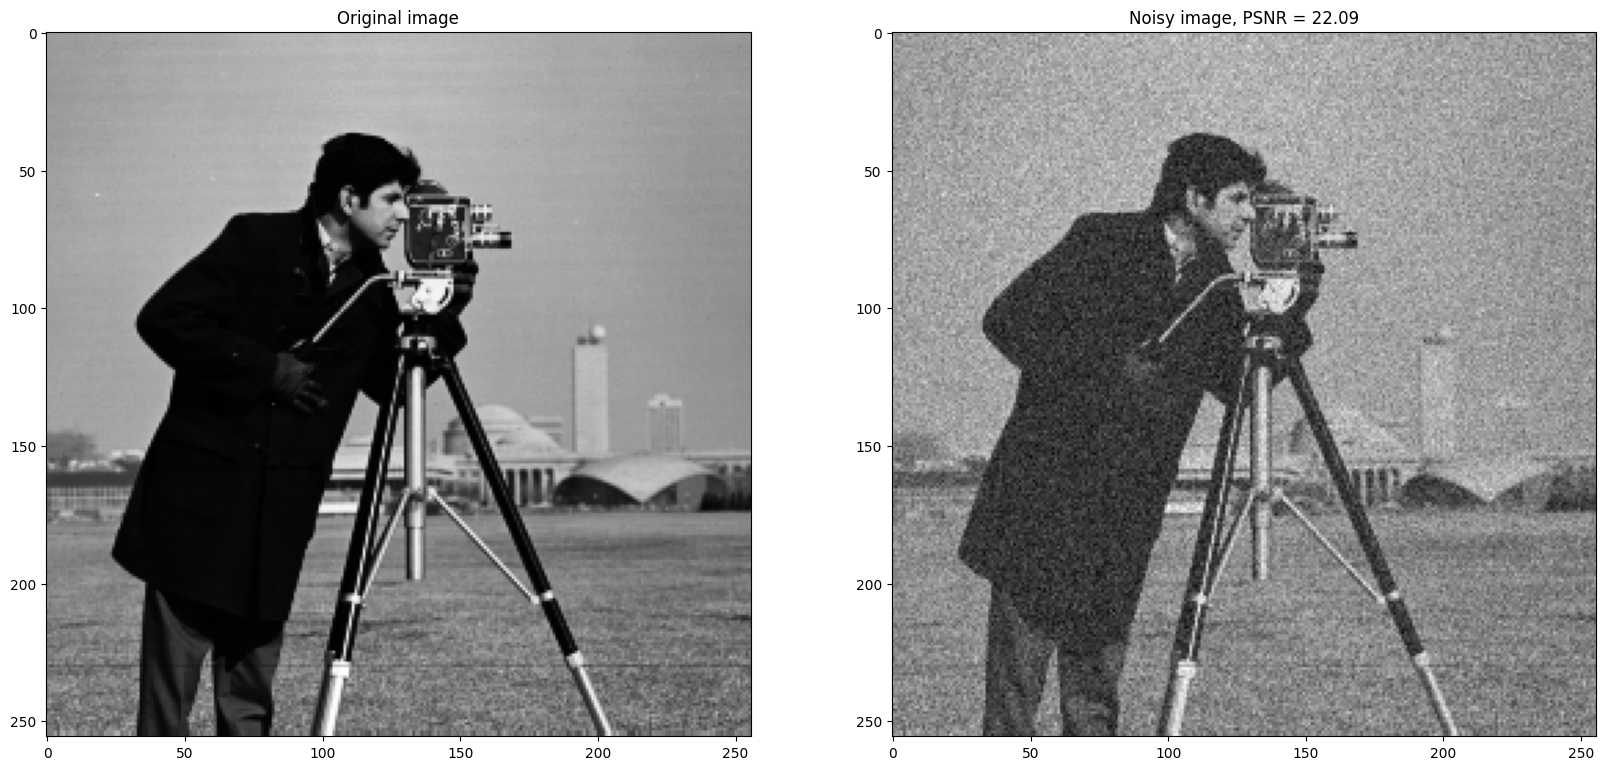

In [197]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Noise estimation
----------------
Compute the horizontal derivative of the image

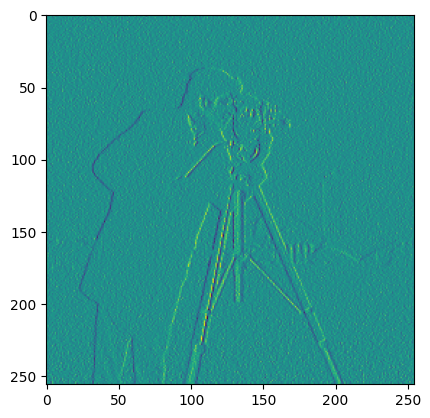

In [198]:
differences = np.diff(noisy_img)
plt.imshow(differences)
plt.show()

Compute sigma as the empirical std

In [199]:
sigma_hat_emp = np.std(noisy_img.flatten())
sigma_hat_emp

np.float64(0.2570322686961769)

Use MAD to estimate the noise level sigma

In [200]:
sigma_hat = np.median(
    np.sort(np.abs(noisy_img.flatten() - np.median(noisy_img.flatten())))
)
sigma_hat

np.float64(0.14315795286738298)

In [201]:
print(f'sigma: {sigma_noise:.3f}, sigma_hat (empirical std): {sigma_hat_emp:.3f}, sigma_hat (MAD): {sigma_hat:.3f}')


sigma: 0.078, sigma_hat (empirical std): 0.257, sigma_hat (MAD): 0.143


## Denoising by Smoothing
Implement Denoising by Smoothing using convolution against a uniform filter of different size.

In [202]:
filter_size = 8

filter = np.random.uniform(0, sigma_noise, size=(filter_size, filter_size))

# compute the convolution with convolve2d()
img_hat_conv = convolve2d(noisy_img, filter, mode='same')


In [203]:
psnr_conv = pnsr(img, img_hat_conv)

Text(0.5, 1.0, 'Noisy image, PSNR = 22.09')

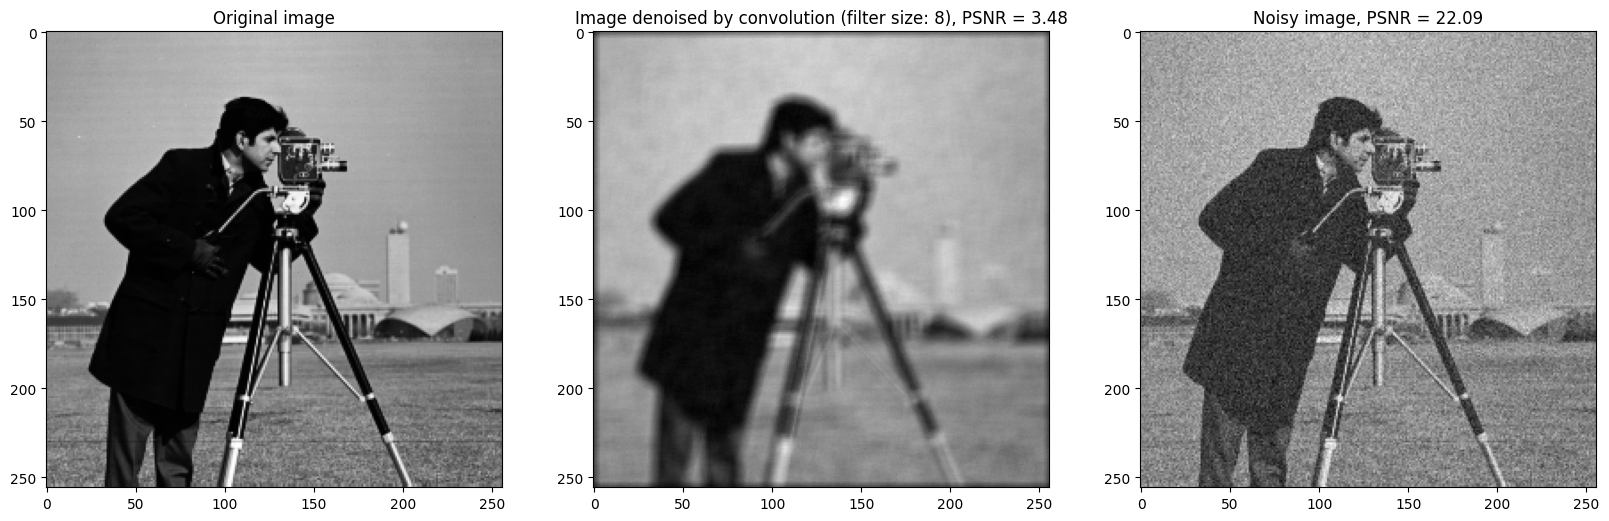

In [204]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(img_hat_conv, cmap='gray')
ax[1].set_title(f'Image denoised by convolution (filter size: {filter_size}), PSNR = {psnr_conv:.2f}')

ax[2].imshow(noisy_img, cmap='gray')
ax[2].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')

## Denoising by Leveraging Sparsity in the DCT Domain

Definition of dct2 and idct2 (they are not builtin functions)

In [205]:
def dct2(s):
    return dct(dct(s.T, norm='ortho').T, norm='ortho')

def idct2(x):
    return idct(idct(x.T, norm='ortho').T, norm='ortho')

In [206]:
# patch size
p = 16

# number of elements in the patch
M = p ** 2

Useful function for plot the 2D DCT dictionary

In [207]:
def get_dictionary_img(D):
    M = D.shape[0]
    p = int(round(np.sqrt(M)))
    bound = 2
    img = np.ones((p*p+bound*(p-1), p*p+bound*(p-1)))
    for i in range(M):
        m = np.mod(i, p)
        n = int((i-m)/p)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

DCT denoising
-------------
Generate the DCT basis

In [208]:
D = np.zeros((M, M))
cnt = 0
for i in range(p):
    for j in range(p):
        a = np.zeros((p, p))
        a[i, j] = 1
        dct_m: np.ndarray = idct2(a)
        D[:, cnt] = dct_m.flatten()
        cnt += 1

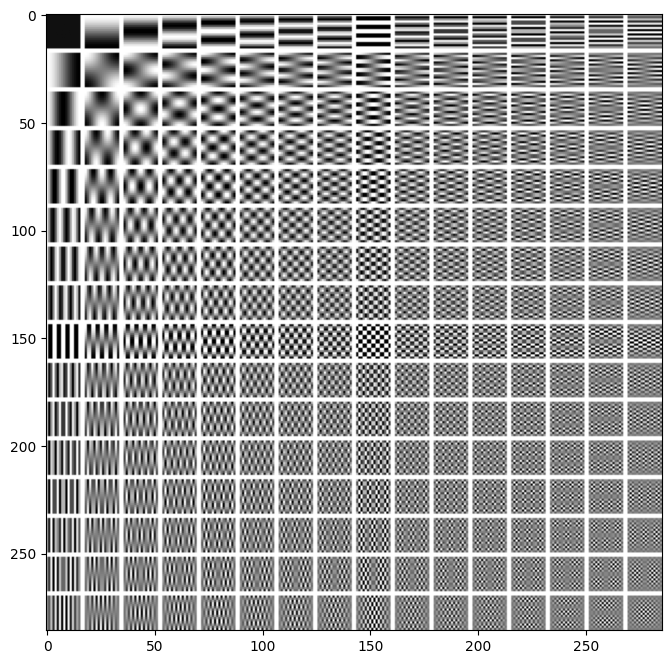

In [209]:
D_img = get_dictionary_img(D)
plt.figure(figsize=(8, 8))
plt.imshow(D_img, cmap='gray')

Denoising: set parameters and initialize the variables

In [210]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# set the threshold for the Hard Thresholding
tau = 3 * sigma_noise # Donoho says: sigma * sqrt(2*log(p^2))
tau = sigma_noise * np.sqrt(2*np.log(p**2))

# define the step
STEP = p//4

Perform the denoising patchwise

In [211]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p,j:j+p]

        # compute the representation w.r.t. the 2D DCT dictionary
        x = dct2(s)

        # perform the hard thresholding (do not perform HT on the DC!)
        thr = np.where(np.abs(x) > tau, x, 0)
        x_HT = thr

        # perform the reconstruction
        s_hat = idct2(x_HT)

        # compute the weights to be used for aggregating the reconstructed patch
        w = np.ones((p, p))

        # accumulate by summation the denoised patch into the denoised image using the computed weight
        # update img_hat
        img_hat[i:i+p,j:j+p] += s_hat

        # accumulate by summation the weights of the current patch in the weight matrix
        # update weights
        weights[i:i+p,j:j+p] += w

Normalize the estimated image with the computed weights, i.e. compute averages

In [212]:
img_hat = img_hat / weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image (step: 4), PSNR = 28.08')

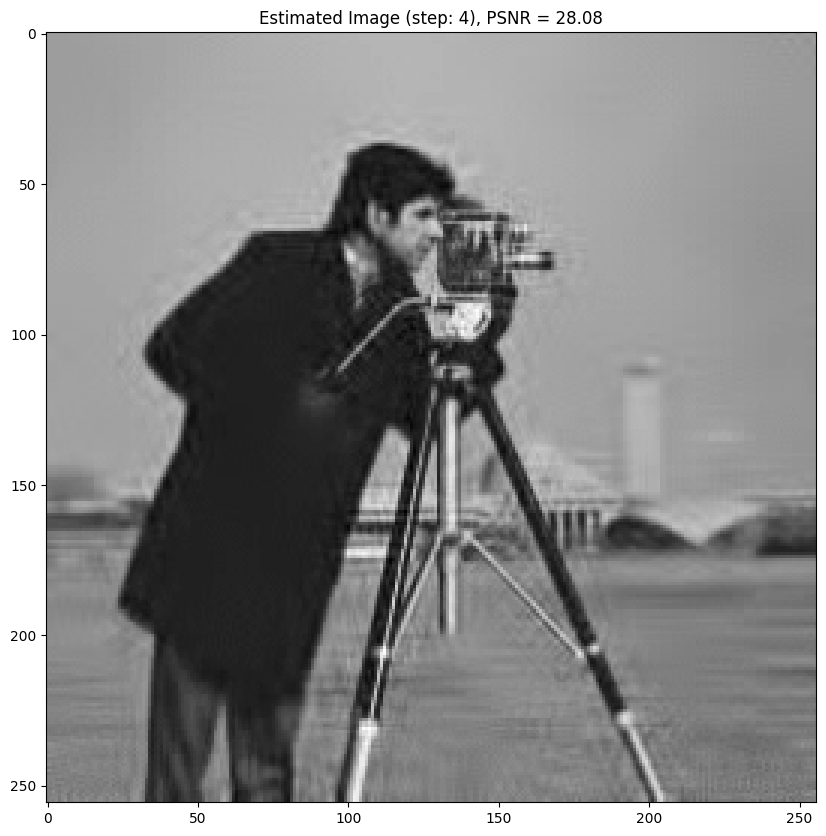

In [213]:
psnr_hat = pnsr(img, img_hat)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image (step: {STEP}), PSNR = {psnr_hat:.2f}')


Wiener Filtering
----------------
Initialize the estimated image via Wiener Filtering

In [214]:
img_hat_wiener = np.zeros_like(img)
weights = np.zeros_like(img)

Perform the denoising patchwise

In [ ]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch from the noisy image with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p,j:j+p]

        # compute the representation w.r.t. the 2D DCT dictionary
        x = dct2(s)

        # extrach the patch from the image estimated by HT with the top left corner at pixel (ii, jj)
        s_hat_HT = img_hat[i:i+p,j:j+p]
        x_hat_HT = dct2(s_hat_HT)

        # perform the Wiener filtering (do not filter the DC!)
        signal_sqrd = x_hat_HT**2
        noise_var = sigma_noise
        x_wie = (signal_sqrd / (signal_sqrd + noise_var)) * x

        # perform the reconstruction
        s_hat_wie = idct2(x_wie)

        # use uniform weights to aggregate the multiple estimates
        w = np.ones((p, p))

        # put the denoised patch into the denoised image using the computed weight
        # update img_hat_wiener
        img_hat_wiener[i:i+p,j:j+p] += s_hat_wie * w

        # store the weight of the current patch in the weight matrix
        # update weights
        weights[i:i+p,j:j+p] += w

# Normalize the estimated image with the computed weights
img_hat_wiener /= weights

Compute the PSNR of the two estimates

Text(0.5, 1.0, 'Wiener Estimate, PSNR = 12.07')

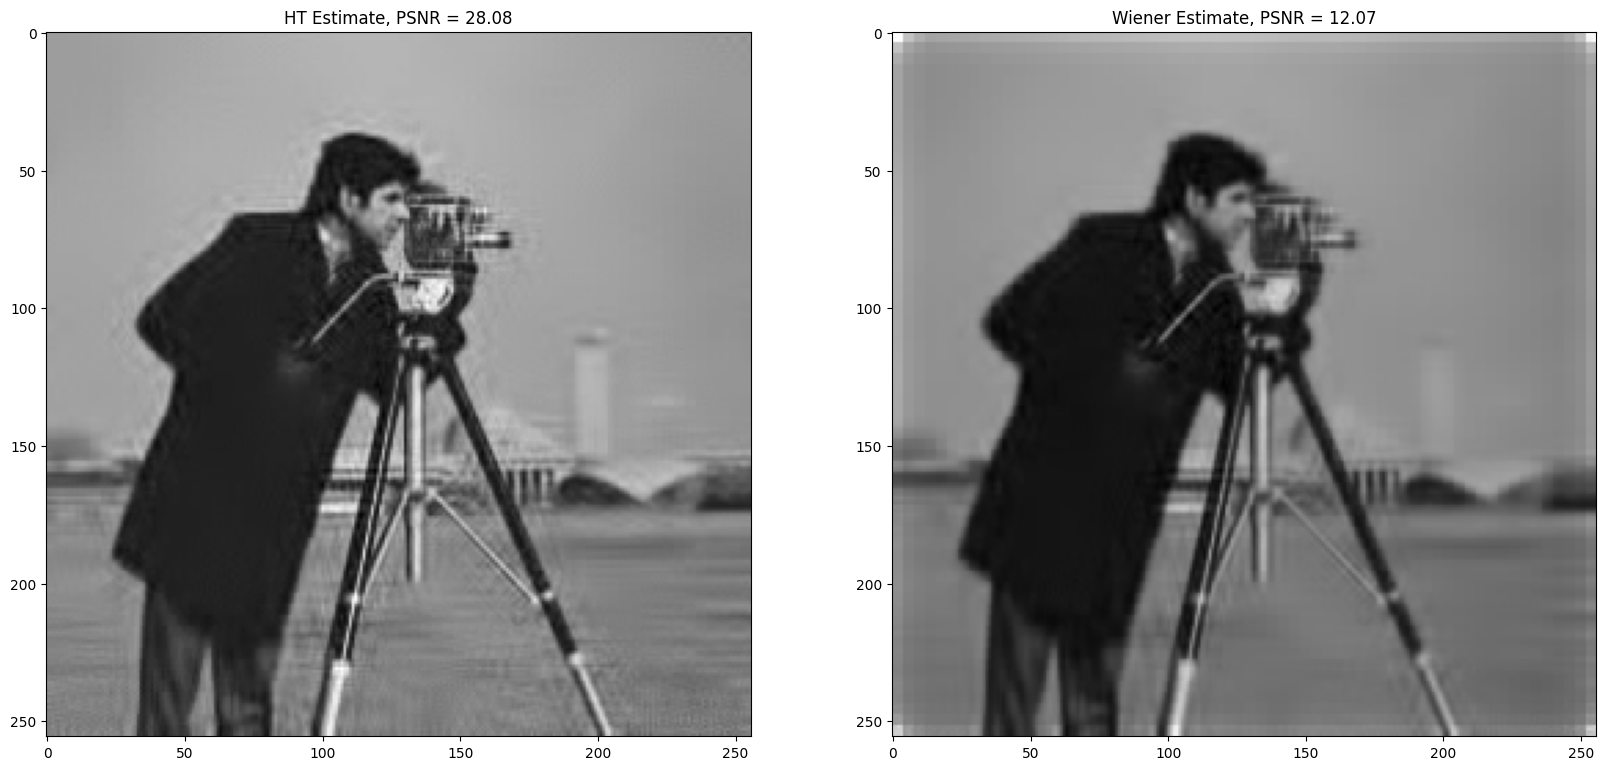

In [220]:
psnr_wiener = pnsr(img, img_hat_wiener)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img_hat, cmap='gray')
ax[0].set_title(f'HT Estimate, PSNR = {psnr_hat:.2f}')

ax[1].imshow(img_hat_wiener, cmap='gray')
ax[1].set_title(f'Wiener Estimate, PSNR = {psnr_wiener:.2f}')


27.67939959519563


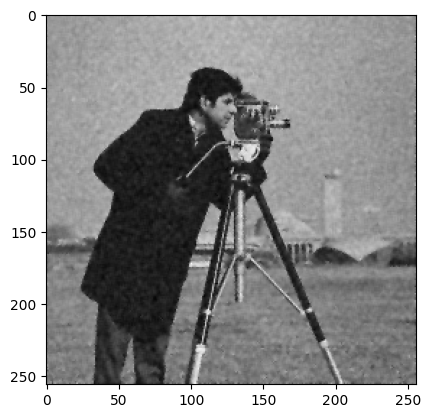

In [218]:
from scipy.signal import wiener

img_hat_wiener_scipy = wiener(noisy_img)

pnsr_scipy_wiener = pnsr(img, img_hat_wiener_scipy)
print(pnsr_scipy_wiener)

plt.imshow(img_hat_wiener_scipy, cmap="gray")
plt.show()